In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import optuna
import os
from tqdm import tqdm

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load photon and electron datasets
photon_file = "Super resolution at the CMS Detector\SinglePhoton.hdf5"
electron_file = "Super resolution at the CMS Detector\SingleElectron.hdf5"

with h5py.File(photon_file, "r") as f:
    X_photon, y_photon = np.array(f["X"]), np.array(f["y"])

with h5py.File(electron_file, "r") as f:
    X_electron, y_electron = np.array(f["X"]), np.array(f["y"])

# Combine datasets
X = np.concatenate([X_photon, X_electron], axis=0)
y = np.concatenate([y_photon, y_electron], axis=0)

# Shuffle and split data
indices = np.arange(len(X))
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 2, 32, 32)
y = torch.tensor(y, dtype=torch.long)
full_dataset = TensorDataset(X, y)

# Split into train-val (80%) and test (20%)
train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])

In [5]:
# Split train-val into train (80%) and val (20%)
tune_size = int(0.8 * train_val_size)
train_subset, val_subset = random_split(train_val_dataset, [tune_size, train_val_size - tune_size])

In [4]:
# Define ResNet-15
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if stride != 1 or in_channels != out_channels else nn.Sequential()
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = [ResNetBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.initial(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc(out)

In [6]:
# Hyperparameter optimization with Optuna

def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    model = ResNet15().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name == "Adam" else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    best_acc = 0
    for epoch in range(5):  # Reduced epochs to 5-10
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Trial {trial.number}, Epoch {epoch+1}, Params: batch={batch_size}, lr={lr:.6f}, opt={optimizer_name}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = correct / total
        print(f"Trial {trial.number}, Epoch {epoch+1}, Validation Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
    return best_acc

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())  # Using TPE sampler
study.optimize(objective, n_trials=5)


[I 2025-03-11 15:58:52,602] A new study created in memory with name: no-name-22de02a6-db2b-431f-ae46-275afc0070a6
C:\Users\Asus\AppData\Local\Temp\ipykernel_11488\4183130570.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Trial 0, Epoch 1, Validation Accuracy: 0.6114


Trial 0, Epoch 2, Validation Accuracy: 0.6164


Trial 0, Epoch 3, Validation Accuracy: 0.6208


Trial 0, Epoch 4, Validation Accuracy: 0.6157


[I 2025-03-11 16:36:16,885] Trial 0 finished with value: 0.6225025100401607 and parameters: {'batch_size': 128, 'lr': 0.0001118021142315225, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6225025100401607.
C:\Users\Asus\AppData\Local\Temp\ipykernel_11488\4183130570.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Trial 0, Epoch 5, Validation Accuracy: 0.6225


Trial 1, Epoch 1, Validation Accuracy: 0.6599


Trial 1, Epoch 2, Validation Accuracy: 0.6857


Trial 1, Epoch 3, Validation Accuracy: 0.7027


Trial 1, Epoch 4, Validation Accuracy: 0.7101


[I 2025-03-11 17:20:13,210] Trial 1 finished with value: 0.7100652610441767 and parameters: {'batch_size': 32, 'lr': 0.0005046009265785884, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7100652610441767.


Trial 1, Epoch 5, Validation Accuracy: 0.6864


Trial 2, Epoch 1, Validation Accuracy: 0.7052


Trial 2, Epoch 2, Validation Accuracy: 0.7082


Trial 2, Epoch 3, Validation Accuracy: 0.7180


Trial 2, Epoch 4, Validation Accuracy: 0.7219


[I 2025-03-11 18:01:17,070] Trial 2 finished with value: 0.7270833333333333 and parameters: {'batch_size': 64, 'lr': 0.0016054737258523577, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7270833333333333.


Trial 2, Epoch 5, Validation Accuracy: 0.7271


Trial 3, Epoch 1, Validation Accuracy: 0.7063


Trial 3, Epoch 2, Validation Accuracy: 0.6451


Trial 3, Epoch 3, Validation Accuracy: 0.7198


Trial 3, Epoch 4, Validation Accuracy: 0.7221


[I 2025-03-11 18:42:09,948] Trial 3 finished with value: 0.722050702811245 and parameters: {'batch_size': 64, 'lr': 0.001983127088323252, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7270833333333333.


Trial 3, Epoch 5, Validation Accuracy: 0.7196


Trial 4, Epoch 1, Validation Accuracy: 0.7039


Trial 4, Epoch 2, Validation Accuracy: 0.7171


Trial 4, Epoch 3, Validation Accuracy: 0.7218


Trial 4, Epoch 4, Validation Accuracy: 0.7237


[I 2025-03-11 19:19:53,485] Trial 4 finished with value: 0.7237449799196787 and parameters: {'batch_size': 128, 'lr': 0.0018578241960028967, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7270833333333333.


Trial 4, Epoch 5, Validation Accuracy: 0.7219


In [10]:
# Train final model with best hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_params = study.best_params
final_model = ResNet15().to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr']) if best_params['optimizer'] == "Adam" else optim.SGD(final_model.parameters(), lr=best_params['lr'], momentum=0.9)

train_loader = DataLoader(train_val_dataset, batch_size=best_params["batch_size"], shuffle=True)
criterion = nn.CrossEntropyLoss()
for epoch in range(20):
    final_model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for inputs, labels in progress_bar: 
        inputs, labels = inputs.to(device), labels.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()
        progress_bar.set_postfix(loss=loss.item())

# Save final model
os.makedirs("models", exist_ok=True)
torch.save(final_model.state_dict(), "models/best_resnet15.pth")

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# Evaluate on training and test dataset
def evaluate_model(model, dataloader, dataset_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f"Evaluation on {dataset_name}:")
    print(classification_report(all_labels, all_preds, digits=4))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

Evaluation on Training Dataset:
              precision    recall  f1-score   support

           0     0.7676    0.7524    0.7599    199080
           1     0.7575    0.7725    0.7649    199320

    accuracy                         0.7625    398400
   macro avg     0.7626    0.7624    0.7624    398400
weighted avg     0.7626    0.7625    0.7624    398400



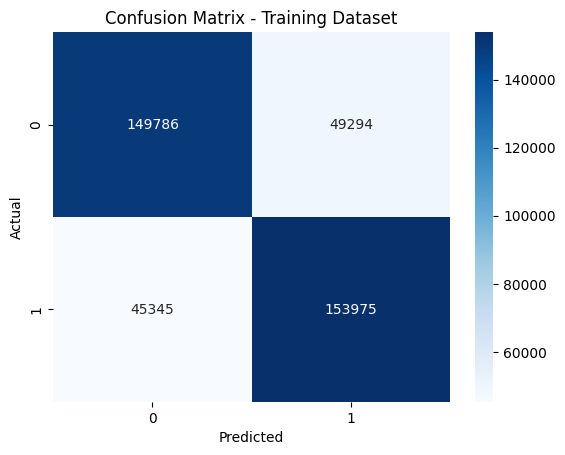

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0     0.7428    0.7262    0.7344     49920
           1     0.7309    0.7474    0.7391     49680

    accuracy                         0.7368     99600
   macro avg     0.7369    0.7368    0.7367     99600
weighted avg     0.7369    0.7368    0.7367     99600



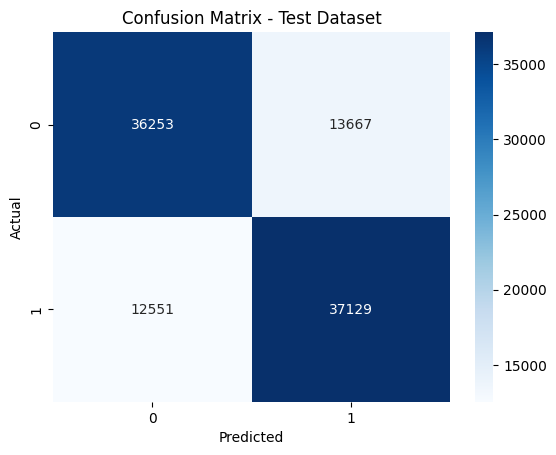

In [12]:
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

evaluate_model(final_model, train_loader, "Training Dataset")
evaluate_model(final_model, test_loader, "Test Dataset")